In [1]:
import os
import pandas as pd
import sys
import json
from google.protobuf.json_format import Parse

sys.path.insert(0, 'compiled_protobufs')
from taskmap_pb2 import TaskMap

qrels_folder = os.path.join(os.getcwd(), 'measurements', 'judgments')
run_cooking_folder = os.path.join(os.getcwd(), 'measurements', 'cooking', 'run_files')
run_diy_folder = os.path.join(os.getcwd(), 'measurements', 'diy', 'run_files')
cooking_runs = os.listdir(run_cooking_folder)
cooking_qrels = os.path.join(qrels_folder, "cooking.qrels")

queries = {
    "COOKING" : pd.read_csv('queries/cooking.csv'),
    "DIY": pd.read_csv('queries/diy.csv'),
}


### Full metrics

In [4]:
## cooking results

from results_helper import get_all_metrics

# results = {}
# for searcher in cooking_runs:
#     run = os.path.join(run_cooking_folder, searcher)
#     searcher_name = searcher[:-4].lower()
#     accuracy = get_accuracy(run, cooking_qrles)
#     results[searcher_name] = accuracy
#     # print(searcher_name, accuracy)
# df = pd.DataFrame(results).transpose()
# df
path = "/home/ubuntu/task-search-quality/measurements/cooking/analysis/all-metrics"

get_all_metrics(run_cooking_folder, cooking_qrels, path, with_t5=None)

,nDCG@5,R@50,Judged@50,Judged@20,P@3,nDCG@3,P@5,nDCG@10,R@10,Judged@10,AP,R@20,P@10
tct-colbertv2+t5,0.618608,0.431942,0.272581,0.453226,0.720430,0.672088,0.638710,0.531589,0.217227,0.575806,0.276202,0.318854,0.498387
tct-colbertv2,0.732627,0.487899,0.312581,0.589516,0.833333,0.753199,0.825806,0.691126,0.311146,0.954839,0.367437,0.372942,0.746774
ance+t5,0.587352,0.381751,0.242903,0.414516,0.672043,0.641950,0.609677,0.498954,0.208416,0.535484,0.245754,0.291260,0.467742
ance,0.659711,0.419621,0.289677,0.587097,0.795699,0.702681,0.735484,0.617704,0.264704,0.953226,0.305103,0.335659,0.679032
bm25+rm3+t5,0.674653,0.441808,0.376452,0.665323,0.817204,0.713313,0.770968,0.632332,0.292084,1.000000,0.338957,0.363462,0.709677
bm25+rm3,0.440452,0.441808,0.376452,0.659677,0.564516,0.452732,0.558065,0.454280,0.224373,1.000000,0.258865,0.303155,0.554839
bm25+t5,0.669918,0.467448,0.388387,0.675000,0.827957,0.711203,0.770968,0.652526,0.306106,1.000000,0.358736,0.387966,0.740323
bm25,0.478709,0.467448,0.388387,0.673387,0.623656,0.500308,0.590323,0.476645,0.234036,1.000000,0.274084,0.320752,0.569355
marqo+t5-target,0.426475,0.234022,0.161935,0.265323,0.473118,0.457230,0.438710,0.354462,0.143509,0.379032,0.144661,0.185508,0.324194
marqo-target,0.380697,0.259852,0.240000,0.529839,0.516129,0.395290,0.493548,0.392218,0.198841,0.995161,0.164186,0.220670,0.496774


In [11]:
path = "/home/ubuntu/task-search-quality/measurements/diy/analysis/all-metrics"
with_t5 = False # True, False, None

diy_qrels = os.path.join(qrels_folder, "diy.qrels")

from results_helper import get_all_metrics, get_all_metrics_searcher

get_all_metrics(run_diy_folder, diy_qrels, path, with_t5=False)
# get_all_metrics_searcher(run_diy_folder, diy_qrels, path, s_name = "colbert")

,Judged@10,P@3,P@10,Judged@50,nDCG@10,AP,nDCG@5,P@5,nDCG@3,R@20,R@50,R@10,Judged@20
tct-colbertv2,1.0,0.833333,0.632,0.4196,0.669332,0.529378,0.706039,0.774,0.746081,0.594048,0.735527,0.453904,0.7390
ance,1.0,0.783333,0.558,0.3886,0.617387,0.438728,0.658291,0.700,0.711243,0.506185,0.645498,0.393009,0.6965
bm25+rm3,1.0,0.736667,0.614,0.4352,0.603841,0.519291,0.602188,0.696,0.623118,0.609026,0.767079,0.429967,0.7585
bm25,1.0,0.726667,0.583,0.4388,0.584395,0.495706,0.603073,0.690,0.623117,0.592493,0.753001,0.410965,0.7665
marqo,1.0,0.710000,0.548,0.4274,0.567989,0.455095,0.582673,0.660,0.610497,0.530082,0.732027,0.393111,0.7250


### Precision Recall Graph

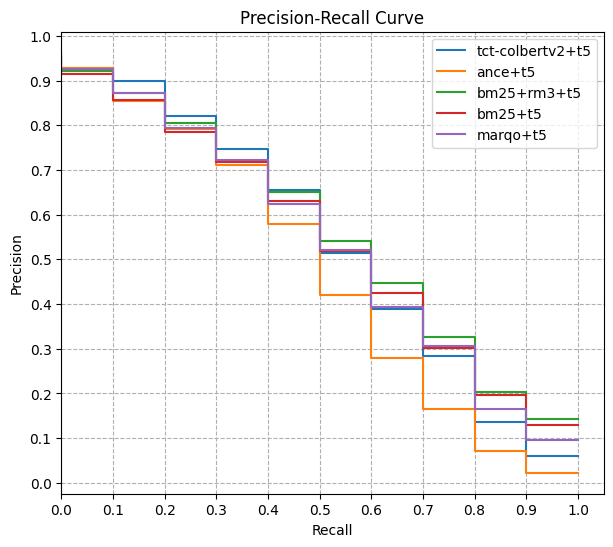

In [12]:
from results_helper import get_precision_recall_graph

diy_qrels = os.path.join(qrels_folder, "diy.qrels")

get_precision_recall_graph(run_diy_folder, diy_qrels, with_t5 = True)

### Query by query Analysis

In [13]:
diy_runs = os.listdir(run_diy_folder)
diy_qrels = os.path.join(qrels_folder, "diy.qrels")

judgments = []
with open(diy_qrels, "r") as f:
    for j in f:
        judgment = j.strip().split(" ")
        judgment[3] = int(judgment[3])
        judgments.append(judgment)

diy_pd = pd.DataFrame(judgments, columns = ['qid', 'run', 'docid', "score"])

diy_pd.head()
stats_pd = diy_pd.groupby(by=["qid"])["score"].agg(['count', 'mean', 'std']).reset_index()
stats_pd["id"] = stats_pd["qid"].str.replace("query-", "").astype(int)
stats_pd = stats_pd.sort_values(by=['id'])
stats_pd.head()


,qid,count,mean,std,id
0,query-0,91,0.505495,0.689180,0
1,query-1,55,0.763636,0.719147,1
12,query-2,44,0.545455,0.663134,2
23,query-3,34,0.558824,0.704581,3
34,query-4,70,0.500000,0.717282,4


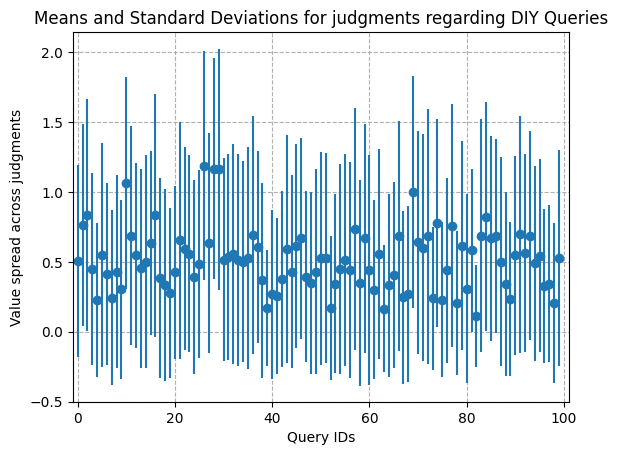

In [14]:
import matplotlib.pyplot as plt

colors = ['red', 'green', 'blue', 'black', 'pink', 'purple', 'orange', 'yellow', 'cyan', 'brown']



# print(len( df["model"].unique()))
# df = pd.read_csv("/home/ubuntu/task-search-quality/measurements/diy/analysis/diy-MAP-best.csv")
# df.head()
# for model_name, color in zip(df["model"].unique(), colors):
#     points_to_plot = df[df["model"] == model_name]
#     # print(len(points_to_plot))
#     filtered_df = stats_pd[stats_pd["qid"].isin(points_to_plot['query_id'])]
#     # print(len(filtered_df))
#     # print(filtered_df)
 
plt.errorbar(x=stats_pd.index, y=stats_pd["mean"], yerr=stats_pd["std"], fmt='o')
plt.title("Means and Standard Deviations for judgments regarding DIY Queries")

plt.xlabel('Query IDs')
plt.ylabel('Value spread across judgments')
plt.grid(linestyle='--')
plt.xlim(-1,101)
plt.ylim(-0.5)
plt.show()

In [8]:
# diy_queries.head()

### Get metrics per query / separate by t5-non-t5

In [15]:
from results_helper import get_metrics, get_raw_query
from ir_measures import *  

queries = pd.read_csv("/home/ubuntu/task-search-quality/queries/diy.csv")  

t5_vals = [False, True]
for t5 in t5_vals:
    ap_vals = get_metrics(run_diy_folder, diy_qrels, AP, t5)
    recall_vals = get_metrics(run_diy_folder, diy_qrels, Recall@50, t5)
    ndcg_vals = get_metrics(run_diy_folder, diy_qrels, nDCG@10, t5)
    ndcg_vals3 = get_metrics(run_diy_folder, diy_qrels, nDCG@3, t5)
    ndcg_vals5 = get_metrics(run_diy_folder, diy_qrels, nDCG@5, t5)
    

    results = {}
    results["DIY"] = {
        "MAP": ap_vals,
        "Recall@50": recall_vals,
        "Ndgc@10": ndcg_vals,
        "Ndgc@3": ndcg_vals3,
        "Ndgc@5": ndcg_vals5,
    }

    analysis_folder = "/home/ubuntu/task-search-quality/measurements/diy/analysis"
    
    if t5:
        analysis_folder += "/t5-results"
    else:
        analysis_folder += "/non-t5-results"

    for metric, df in results["DIY"].items():
        pivoted_df = df.pivot(index='query_id', columns='model', values='metric_val').reset_index()
        pivoted_df["query"] = pivoted_df.apply(lambda x: get_raw_query(x, queries), axis=1)
        pivoted_df.to_csv(os.path.join(analysis_folder, metric+".csv"), index=False)

pivoted_df.head()


model,query_id,TCT-ColBERTv2+t5,ance+t5,bm25+rm3+t5,bm25+t5,marqo+t5,query
0,query-0,0.425485,0.425485,0.563261,0.563261,0.509961,how to choose a good hairstyle for men
1,query-1,0.710971,0.710971,0.691783,0.691783,0.710971,how to learn a new language
2,query-10,0.786014,0.786014,0.830420,0.853932,0.934397,how to style curly hair
3,query-11,0.819973,0.827404,0.657824,0.584790,0.819973,how to write a biography book
4,query-12,0.592222,0.000000,0.550831,0.550831,0.681336,how to grow apples


### Graph Box Plots for MAP, nDCG@10, Recall@50

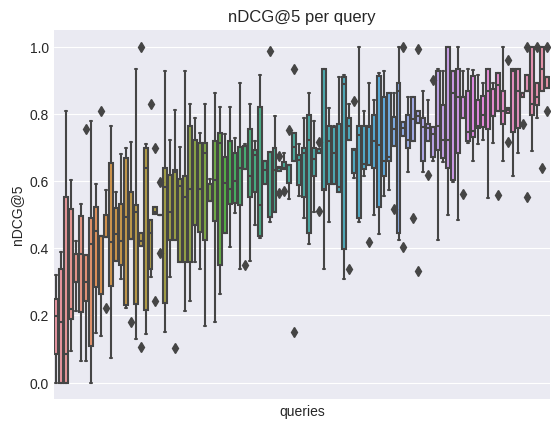

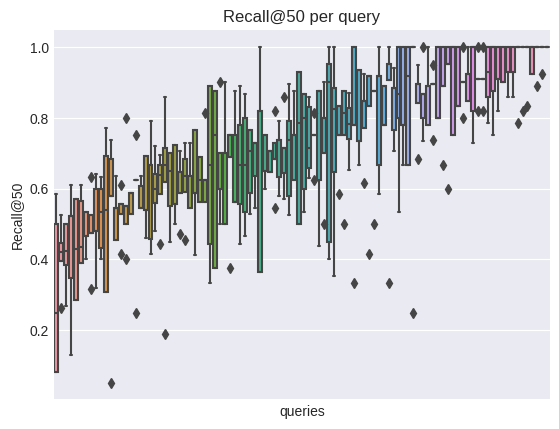

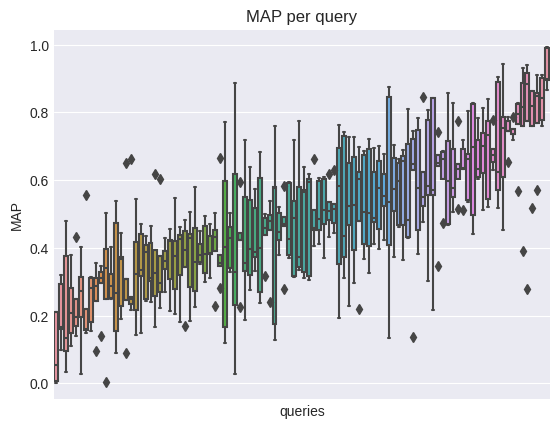

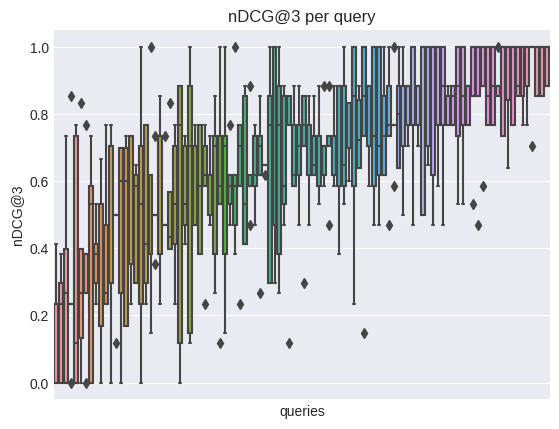

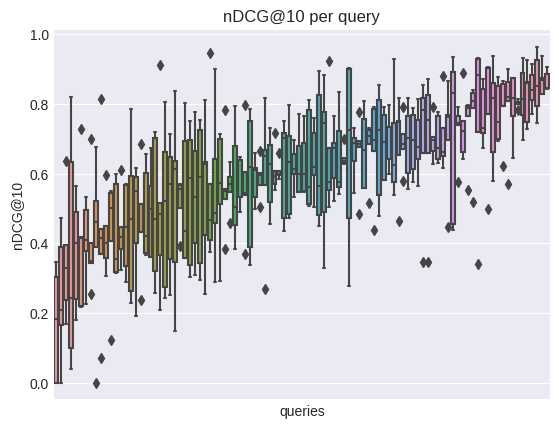

,query_id,TCT-ColBERTv2,ance,bm25,bm25+rm3,marqo,query,mean
89,query-9,0.302656,0.344783,0.000000,0.000000,0.183110,how can I screw a nail,0.166110
75,query-77,0.388077,0.165802,0.207393,0.000000,0.473636,how to wash a newborn baby,0.246982
40,query-45,0.168427,0.636005,0.393939,0.330255,0.236746,how to warm up before a run,0.353074
58,query-61,0.819244,0.098154,0.243689,0.039826,0.631811,how to make a coaster,0.366545
3,query-11,0.489555,0.563070,0.241262,0.180261,0.400220,how to write a biography book,0.374874


In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

analysis_folder = "/home/ubuntu/task-search-quality/measurements/diy/analysis/non-t5-results"

files = os.listdir(analysis_folder)

for file in files:
    
    # print(file)
    filepath = os.path.join(analysis_folder, file)
    df = pd.read_csv(filepath) # index_col="query_id"
    df["mean"] = df.mean(axis=1, numeric_only=True)
    df = df.sort_values(by=["mean"], ascending=True)
    # print(df.columns)
    df_T = df[df.columns[1:-2]].T
    # print(df_T)
    sns.boxplot(data=df_T)
    
    y_label = file.split(".")[0]
    
    plt.title(f"{y_label} per query")
    plt.ylabel(y_label)
    plt.xlabel("queries")
    plt.xticks([])
    plt.show()

df.head()


### Difficult queries performance

In [36]:
analysis_folder = "/home/ubuntu/task-search-quality/measurements/diy/analysis/non-t5-results"

files = os.listdir(analysis_folder)

results = {}

thresholds = [5,10, 15,20]

for threshold in thresholds:
    for file in files:
        
        # print(file)
        if "Recall" in file:
            continue
        filepath = os.path.join(analysis_folder, file)
        df = pd.read_csv(filepath) # index_col="query_id"
        df["mean"] = df.mean(axis=1, numeric_only=True)
        df = df.sort_values(by=["mean"], ascending=True)
        hardest_10 = df.head(threshold)
        hardest_10 = hardest_10.drop(columns = ["query_id", "query"])
        hardest_10.mean()
        print(file)
        print(hardest_10.mean())
        results[(threshold, file.split('.')[0])] = hardest_10.mean()

nDCG@5.csv
TCT-ColBERTv2    0.414507
ance             0.300100
bm25             0.187031
bm25+rm3         0.097374
marqo            0.290110
mean             0.257824
dtype: float64
MAP.csv
TCT-ColBERTv2    0.260246
ance             0.294699
bm25             0.125380
bm25+rm3         0.108340
marqo            0.201310
mean             0.197995
dtype: float64
nDCG@3.csv
TCT-ColBERTv2    0.320531
ance             0.276443
bm25             0.182773
bm25+rm3         0.046928
marqo            0.446928
mean             0.254721
dtype: float64
nDCG@10.csv
TCT-ColBERTv2    0.433592
ance             0.361563
bm25             0.217257
bm25+rm3         0.110068
marqo            0.385105
mean             0.301517
dtype: float64
nDCG@5.csv
TCT-ColBERTv2    0.452697
ance             0.363691
bm25             0.257496
bm25+rm3         0.170321
marqo            0.330864
mean             0.315014
dtype: float64
MAP.csv
TCT-ColBERTv2    0.295641
ance             0.284265
bm25             0.178387
bm25+r

/tmp/ipykernel_597796/3810547552.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


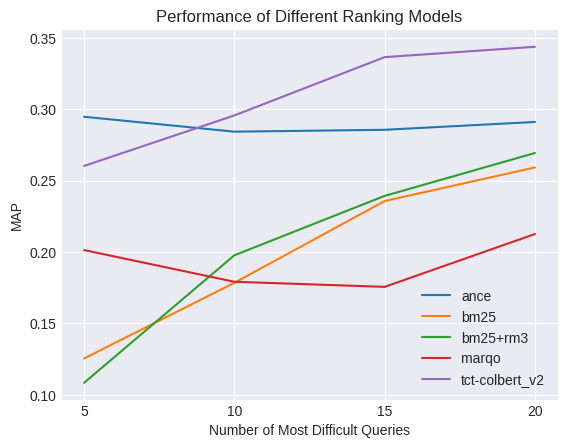

/tmp/ipykernel_597796/3810547552.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


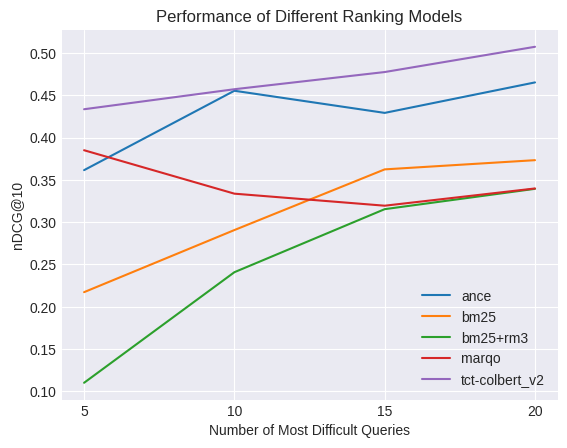

/tmp/ipykernel_597796/3810547552.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


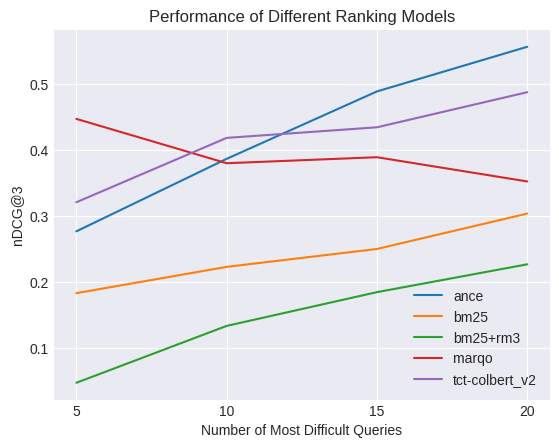

/tmp/ipykernel_597796/3810547552.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


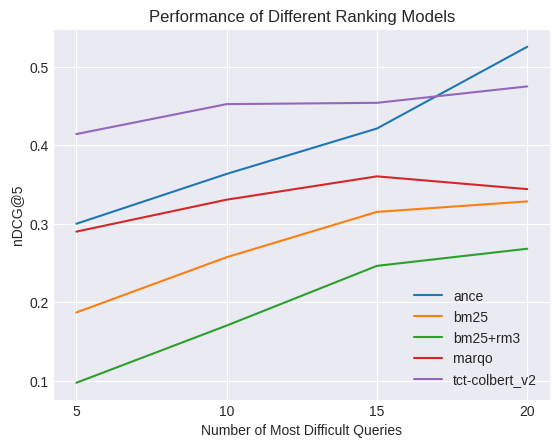

In [37]:
res = []
for threshold, vals in results.items():
        res.append({
            "metric": threshold[1],
            "threshold": threshold[0],
            "ance": vals["ance"],        
            "bm25": vals["bm25"],       
            "bm25+rm3": vals["bm25+rm3"],      
            "marqo": vals["marqo"],        
            "tct-colbert_v2": vals["TCT-ColBERTv2"],        
        })
df_hardest = pd.DataFrame(res)
df_hardest.sort_values(by="metric", inplace=True)
df_hardest.head()


import matplotlib.pyplot as plt

for metric in df_hardest["metric"].unique():
    df = df_hardest[df_hardest["metric"] == metric]
    # set the plot style
    plt.style.use('seaborn-darkgrid')
    # plot the line plot
    for model in df.columns[2:]:
        plt.plot(df["threshold"], df[model], label=model)

    plt.xticks([5, 10, 15, 20])
    plt.ylabel(df["metric"].iloc[0])
    plt.xlabel("Number of Most Difficult Queries")
    # set the title
    plt.title("Performance of Different Ranking Models")
    # add the legend
    plt.legend()
    # show the plot
    plt.show()

### Easy queries performance

In [38]:
analysis_folder = "/home/ubuntu/task-search-quality/measurements/diy/analysis/non-t5-results"

files = os.listdir(analysis_folder)

results = {}

thresholds = range(1,21)

for threshold in thresholds:
    for file in files:
        
        # print(file)
        if "Recall" in file:
            continue
        filepath = os.path.join(analysis_folder, file)
        df = pd.read_csv(filepath) # index_col="query_id"
        df["mean"] = df.mean(axis=1, numeric_only=True)
        df = df.sort_values(by=["mean"], ascending=True)
        easiest = df.tail(threshold)
        easiest = easiest.drop(columns = ["query_id", "query"])
        easiest.mean()
        # print(file)
        # print(easiest.mean())
        results[(threshold, file.split('.')[0])] = easiest.mean()
    # print(file)
    # print(hardest.mean())

/tmp/ipykernel_597796/3312905535.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


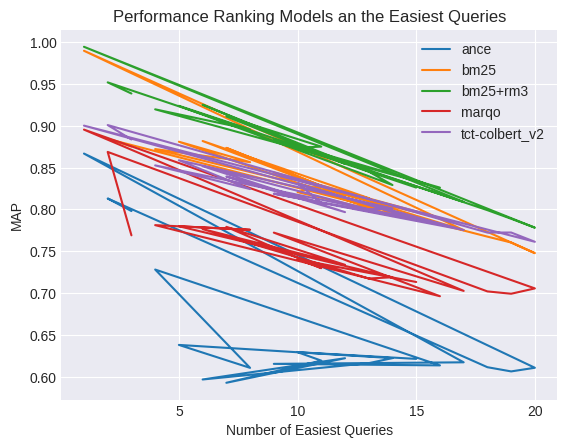

/tmp/ipykernel_597796/3312905535.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


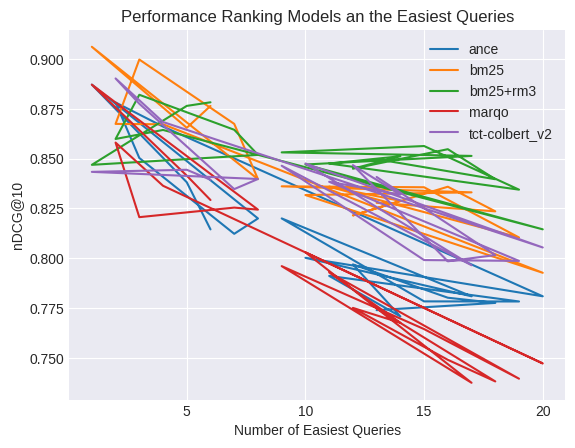

/tmp/ipykernel_597796/3312905535.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


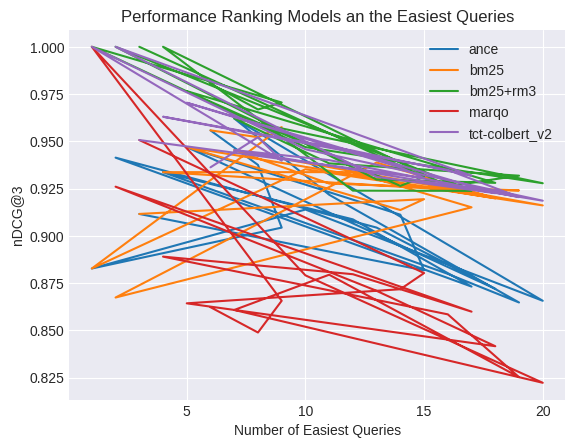

/tmp/ipykernel_597796/3312905535.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


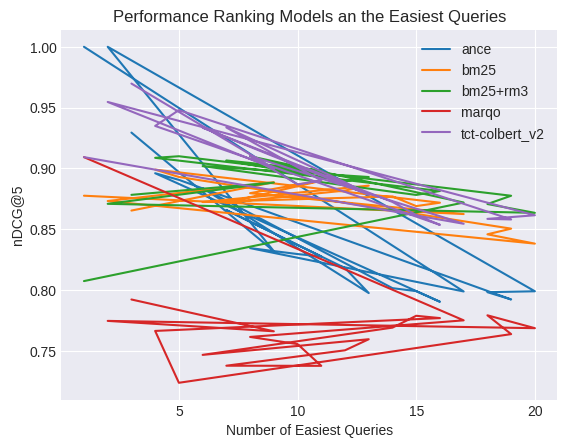

In [39]:
res = []
for threshold, vals in results.items():
        res.append({
            "metric": threshold[1],
            "threshold": threshold[0],
            "ance": vals["ance"],        
            "bm25": vals["bm25"],       
            "bm25+rm3": vals["bm25+rm3"],      
            "marqo": vals["marqo"],        
            "tct-colbert_v2": vals["TCT-ColBERTv2"],        
        })
df_hardest = pd.DataFrame(res)
df_hardest.sort_values(by="metric", inplace=True)
df_hardest.head()


import matplotlib.pyplot as plt

for metric in df_hardest["metric"].unique():
    df = df_hardest[df_hardest["metric"] == metric]
    # set the plot style
    plt.style.use('seaborn-darkgrid')
    # plot the line plot
    for model in df.columns[2:]:
        plt.plot(df["threshold"], df[model], label=model)

    plt.xticks([5, 10, 15, 20])
    plt.ylabel(df["metric"].iloc[0])
    plt.xlabel("Number of Easiest Queries")
    # set the title
    plt.title("Performance Ranking Models an the Easiest Queries")
    # add the legend
    plt.legend()
    # show the plot
    plt.show()

In [40]:
analysis_folder = "/home/ubuntu/task-search-quality/measurements/diy/analysis/non-t5-results"

files = os.listdir(analysis_folder)
results = {}

for file in files:
    if "Recall" not in file:
        continue
    print(file)
    filepath = os.path.join(analysis_folder, file)
    df = pd.read_csv(filepath) # index_col="query_id"
    # df["mean"] = df.mean(axis=1, numeric_only=True)
    df["std"] = df.std(axis=1, numeric_only=True)
    df = df.sort_values(by=["std"], ascending=False)
    # df.drop(columns=["query", "std"], inplace=True)
    # easiest = df.head(threshold)
    # easiest.head()
    # print('hello')
df.head()
    # easiest = easiest.drop(columns = ["query_id", "query"])
    # easiest.mean()
    # # print(file)
    # # print(easiest.mean())
    # results[(threshold, file.split('.')[0])] = easiest.mean()

Recall@50.csv


,query_id,TCT-ColBERTv2,ance,bm25,bm25+rm3,marqo,query,std
58,query-61,1.000000,0.250000,1.000000,1.000000,1.000000,how to make a coaster,0.335410
73,query-75,0.818182,1.000000,0.363636,0.363636,0.818182,how to build a gaming computer,0.291760
49,query-53,0.900000,0.400000,0.950000,1.000000,0.450000,how to put up wallpaper,0.290259
57,query-60,0.904762,0.333333,0.952381,0.952381,1.000000,how to make napkin designs,0.278887
0,query-0,0.684211,0.736842,0.578947,0.578947,0.052632,how to choose a good hairstyle for men,0.273482


#### Comparison between TCT-Colbert_v2 vs TCT-Colbert_v2+t5 vs BM25+RM3+T5

In [41]:
df = get_all_metrics(run_diy_folder, diy_qrels, path, with_t5=None)
df.loc[["tct-colbertv2", "tct-colbertv2+t5", 'bm25+rm3+t5']]

,Judged@10,P@3,P@10,Judged@50,nDCG@10,AP,nDCG@5,P@5,nDCG@3,R@20,R@50,R@10,Judged@20
tct-colbertv2,1.0,0.833333,0.632,0.4196,0.669332,0.529378,0.706039,0.774,0.746081,0.594048,0.735527,0.453904,0.7390
tct-colbertv2+t5,1.0,0.836667,0.675,0.4196,0.710087,0.568235,0.730889,0.804,0.740442,0.649272,0.735527,0.480994,0.7855
bm25+rm3+t5,1.0,0.806667,0.699,0.4352,0.706960,0.587040,0.709245,0.780,0.729661,0.666616,0.767079,0.498971,0.7905


In [42]:
paths = []
paths.append("/home/ubuntu/task-search-quality/measurements/diy/analysis/non-t5-results/nDCG@3.csv")
paths.append("/home/ubuntu/task-search-quality/measurements/diy/analysis/t5-results/nDCG@3.csv")
print(paths)
df1 = pd.read_csv(paths[0])
df2 = pd.read_csv(paths[1])
df2.drop(columns=["query"], inplace=True)
# print(df1.columns)
df = pd.merge(
    df1, df2,
    on=["query_id"]
)
df = df[["query_id","query", "TCT-ColBERTv2", "TCT-ColBERTv2+t5", "bm25+rm3+t5"]].sort_values(by=["TCT-ColBERTv2"])

df.head()

['/home/ubuntu/task-search-quality/measurements/diy/analysis/non-t5-results/nDCG@3.csv', '/home/ubuntu/task-search-quality/measurements/diy/analysis/t5-results/nDCG@3.csv']


,query_id,query,TCT-ColBERTv2,TCT-ColBERTv2+t5,bm25+rm3+t5
11,query-19,how to wash a stainless steel pan,0.000000,0.586598,0.234639
59,query-62,how to draw a birthday card,0.234639,0.000000,0.000000
75,query-77,how to wash a newborn baby,0.234639,0.469279,0.765361
76,query-78,how to train a dog to behave outside,0.234639,0.648041,0.413402
89,query-9,how can I screw a nail,0.234639,0.586598,0.469279


/tmp/ipykernel_597796/1993930768.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


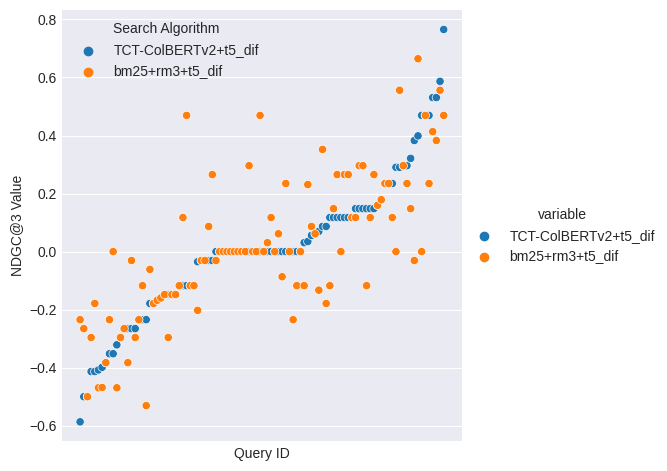

In [43]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


df["bm25+rm3+t5_dif"] = df["TCT-ColBERTv2"] - df["bm25+rm3+t5"]
df["TCT-ColBERTv2+t5_dif"] = df["TCT-ColBERTv2"] - df["TCT-ColBERTv2+t5"]

df.sort_values(by=["TCT-ColBERTv2+t5_dif"], inplace=True)
# df = df[["query_id", "TCT-ColBERTv2+t5_dif", "bm25+rm3+t5_dif"]]

# Plot the dots for each column using relplot
sns.relplot(x='query_id', y='value', kind='scatter', hue='variable', data=pd.melt(df[["query_id", "TCT-ColBERTv2+t5_dif", "bm25+rm3+t5_dif"]], id_vars='query_id'))

# Add labels to the x and y axes
plt.xlabel("Query ID")
plt.ylabel("NDGC@3 Value")
plt.xticks([])
plt.style.use('seaborn-darkgrid')
plt.legend(title="Search Algorithm")
plt.show()

In [25]:
df.head()

,query_id,query,TCT-ColBERTv2,TCT-ColBERTv2+t5,bm25+rm3+t5,bm25+rm3+t5_dif,TCT-ColBERTv2+t5_dif
11,query-19,how to wash a stainless steel pan,0.000000,0.586598,0.234639,-0.234639,-0.586598
54,query-58,how to make a candles that smell well,0.382680,0.882680,0.648041,-0.265361,-0.500000
26,query-32,paint nails with patterns,0.500000,1.000000,1.000000,-0.500000,-0.500000
22,query-29,paint a metal fence,0.586598,1.000000,0.882680,-0.296082,-0.413402
76,query-78,how to train a dog to behave outside,0.234639,0.648041,0.413402,-0.178762,-0.413402


In [26]:
df.tail()

,query_id,query,TCT-ColBERTv2,TCT-ColBERTv2+t5,bm25+rm3+t5,bm25+rm3+t5_dif,TCT-ColBERTv2+t5_dif
87,query-88,how to catch a fly,1.000000,0.530721,0.765361,0.234639,0.469279
90,query-90,how to make an asian lantern,1.000000,0.469279,0.586598,0.413402,0.530721
34,query-4,how do I decorate an office,1.000000,0.469279,0.617320,0.382680,0.530721
43,query-48,how to change a child's diaper,0.851959,0.265361,0.296082,0.555877,0.586598
24,query-30,create an outdoor fireplace,1.000000,0.234639,0.530721,0.469279,0.765361


In [27]:
df.sort_values(by=["bm25+rm3+t5_dif"], inplace=True)
df.head()


,query_id,query,TCT-ColBERTv2,TCT-ColBERTv2+t5,bm25+rm3+t5,bm25+rm3+t5_dif,TCT-ColBERTv2+t5_dif
75,query-77,how to wash a newborn baby,0.234639,0.469279,0.765361,-0.530721,-0.234639
26,query-32,paint nails with patterns,0.500000,1.000000,1.000000,-0.500000,-0.500000
66,query-69,how to make christmas ornaments,0.530721,0.851959,1.000000,-0.469279,-0.321238
55,query-59,how to build a toy for a pet,0.296082,0.703918,0.765361,-0.469279,-0.407836
96,query-96,how to fix a door handle,0.398739,0.797478,0.867087,-0.468348,-0.398739


In [28]:
df.tail()

,query_id,query,TCT-ColBERTv2,TCT-ColBERTv2+t5,bm25+rm3+t5,bm25+rm3+t5_dif,TCT-ColBERTv2+t5_dif
44,query-49,how to make a bubble bath,0.882680,1.000000,0.413402,0.469279,-0.117320
24,query-30,create an outdoor fireplace,1.000000,0.234639,0.530721,0.469279,0.765361
78,query-8,how do I clean the fridge,0.703918,0.413402,0.148041,0.555877,0.290516
43,query-48,how to change a child's diaper,0.851959,0.265361,0.296082,0.555877,0.586598
63,query-66,how to make stickers,0.664565,0.265826,0.000000,0.664565,0.398739


['/home/ubuntu/task-search-quality/measurements/diy/analysis/non-t5-results/nDCG@5.csv', '/home/ubuntu/task-search-quality/measurements/diy/analysis/t5-results/nDCG@5.csv']


/tmp/ipykernel_597796/3287895752.py:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


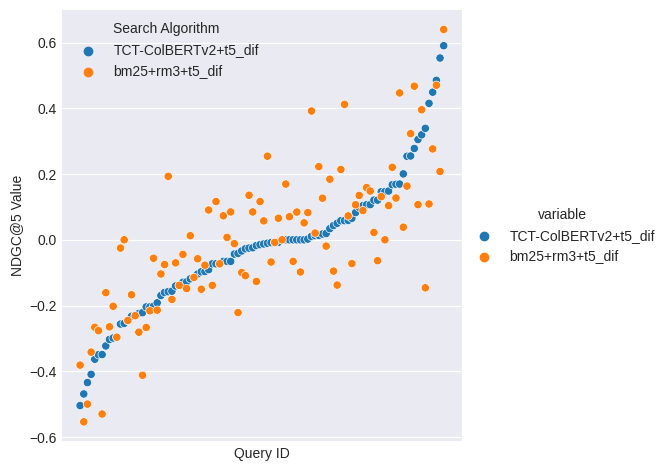

In [29]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

paths = []
paths.append("/home/ubuntu/task-search-quality/measurements/diy/analysis/non-t5-results/nDCG@5.csv")
paths.append("/home/ubuntu/task-search-quality/measurements/diy/analysis/t5-results/nDCG@5.csv")
print(paths)
df1 = pd.read_csv(paths[0])
df2 = pd.read_csv(paths[1])
df2.drop(columns=["query"], inplace=True)
# print(df1.columns)
df = pd.merge(
    df1, df2,
    on=["query_id"]
)
df = df[["query_id","query", "TCT-ColBERTv2", "TCT-ColBERTv2+t5", "bm25+rm3+t5"]].sort_values(by=["TCT-ColBERTv2"])


df["bm25+rm3+t5_dif"] = df["TCT-ColBERTv2"] - df["bm25+rm3+t5"]
df["TCT-ColBERTv2+t5_dif"] = df["TCT-ColBERTv2"] - df["TCT-ColBERTv2+t5"]

df.sort_values(by=["TCT-ColBERTv2+t5_dif"], inplace=True)
# df = df[["query_id", "TCT-ColBERTv2+t5_dif", "bm25+rm3+t5_dif"]]

# Plot the dots for each column using relplot
sns.relplot(x='query_id', y='value', kind='scatter', hue='variable', data=pd.melt(df[["query_id", "TCT-ColBERTv2+t5_dif", "bm25+rm3+t5_dif"]], id_vars='query_id'))

# Add labels to the x and y axes
plt.xlabel("Query ID")
plt.ylabel("NDGC@5 Value")
plt.xticks([])
plt.style.use('seaborn-darkgrid')
plt.legend(title="Search Algorithm")
plt.show()

In [30]:
df.head()

,query_id,query,TCT-ColBERTv2,TCT-ColBERTv2+t5,bm25+rm3+t5,bm25+rm3+t5_dif,TCT-ColBERTv2+t5_dif
11,query-19,how to wash a stainless steel pan,0.065603,0.570019,0.446854,-0.381251,-0.504416
32,query-38,how to gain muscle,0.446153,0.915210,1.000000,-0.553847,-0.469057
26,query-32,paint nails with patterns,0.500000,0.934397,1.000000,-0.500000,-0.434397
42,query-47,how to install a sprinkler system,0.568346,0.977724,0.910191,-0.341844,-0.409378
66,query-69,how to make christmas ornaments,0.529635,0.893007,0.795761,-0.266126,-0.363372


In [31]:
df.tail()

,query_id,query,TCT-ColBERTv2,TCT-ColBERTv2+t5,bm25+rm3+t5,bm25+rm3+t5_dif,TCT-ColBERTv2+t5_dif
79,query-80,how to make a professional book cover,0.819973,0.404763,0.710971,0.109002,0.415210
34,query-4,how do I decorate an office,1.000000,0.550831,0.723427,0.276573,0.449169
72,query-74,how to cut my own hair,1.000000,0.514771,0.529635,0.470365,0.485229
24,query-30,create an outdoor fireplace,0.795761,0.242614,0.587806,0.207955,0.553146
63,query-66,how to make stickers,0.808925,0.218370,0.168954,0.639971,0.590555


In [32]:
df.sort_values(by=["bm25+rm3+t5_dif"], inplace=True)
df.head()

,query_id,query,TCT-ColBERTv2,TCT-ColBERTv2+t5,bm25+rm3+t5,bm25+rm3+t5_dif,TCT-ColBERTv2+t5_dif
32,query-38,how to gain muscle,0.446153,0.915210,1.000000,-0.553847,-0.469057
75,query-77,how to wash a newborn baby,0.196874,0.546071,0.726965,-0.530091,-0.349197
26,query-32,paint nails with patterns,0.500000,0.934397,1.000000,-0.500000,-0.434397
55,query-59,how to build a toy for a pet,0.418226,0.639945,0.830420,-0.412194,-0.221720
11,query-19,how to wash a stainless steel pan,0.065603,0.570019,0.446854,-0.381251,-0.504416


In [33]:
df.tail()

,query_id,query,TCT-ColBERTv2,TCT-ColBERTv2+t5,bm25+rm3+t5,bm25+rm3+t5_dif,TCT-ColBERTv2+t5_dif
64,query-67,how to make my own fridge magnets,0.926966,0.868795,0.514771,0.412194,0.058171
59,query-62,how to draw a birthday card,0.446854,0.277273,0.000000,0.446854,0.169580
43,query-48,how to change a child's diaper,0.746939,0.469057,0.279589,0.467350,0.277882
72,query-74,how to cut my own hair,1.000000,0.514771,0.529635,0.470365,0.485229
63,query-66,how to make stickers,0.808925,0.218370,0.168954,0.639971,0.590555


#### How nDCG@n changes with increasing n

Index([nDCG@9, nDCG@2, nDCG@8, nDCG@4, nDCG@3, nDCG@6, nDCG@10, nDCG@5, nDCG@7,
       nDCG@1],
      dtype='object')
    TCT-ColBERTv2  TCT-ColBERTv2+t5  bm25+rm3+t5
1        0.860000          0.805000     0.805000
2        0.772494          0.754245     0.767785
3        0.746081          0.740442     0.729661
4        0.719198          0.732120     0.720841
5        0.706039          0.730889     0.709245
6        0.695480          0.729946     0.702986
7        0.686986          0.719657     0.700871
8        0.673594          0.715038     0.695766
9        0.671849          0.710505     0.702882
10       0.669332          0.710087     0.706960


/tmp/ipykernel_600879/3900529423.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


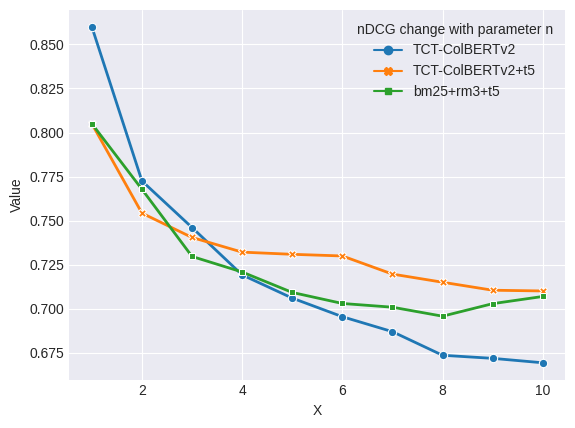

In [29]:
from results_helper import get_nDGCs_per_run

ndgc_folder = "/home/ubuntu/task-search-quality/measurements/diy/analysis/nDCG-comparison"
diy_qrels = os.path.join(qrels_folder, "diy.qrels")
run_diy_folder = os.path.join(os.getcwd(), 'measurements', 'diy', 'run_files')
runs = ['TCT-ColBERTv2.run', 'TCT-ColBERTv2+t5.run' , 'bm25+rm3+t5.run']

results = {}
for run in runs:
    run_path = os.path.join(run_diy_folder, run)
    ndgcs = get_nDGCs_per_run(run_path, diy_qrels)
    results[run.split('.')[0]] = ndgcs
df = pd.DataFrame(results)
print(df.index)

df.index = [int(str(i).split("@")[1]) for i in df.index]
df.sort_index(inplace=True)
print(df)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.lineplot(data=df, dashes=False, linewidth=2, markers=True,)
plt.style.use('seaborn-darkgrid')

# Add labels to the x and y axes
plt.xlabel("X")
plt.ylabel("Value")

# Add a legend
plt.legend(title="nDCG change with parameter n")

# Show the plot
plt.show()
    
